# Tarea: Experimentación con Redes Neuronales Convolucionales (CNN)
## Computer Vision con TensorFlow

**Objetivo**: Explorar cómo diferentes arquitecturas convolucionales y técnicas de regularización afectan el desempeño en tareas de clasificación de imágenes usando el dataset CIFAR-10.

---

## Instrucciones Generales

En este ejercicio trabajarás con el dataset CIFAR-10 (imágenes de 32x32 píxeles en 10 categorías) y arquitecturas de redes neuronales convolucionales. El código base ya está en su mayoría implementado, tu trabajo consistirá en:

1. Completar partes específicas del código según las instrucciones
2. Ejecutar 10 experimentos modificando arquitecturas y parámetros
3. Analizar los resultados de cada experimento
4. Responder las preguntas específicas de cada ejercicio

**Entrega**: Completa todos los ejercicios en este notebook, ejecuta las celdas correspondientes, y responde las preguntas en las celdas de markdown proporcionadas. El notebook se sube a github y el enlace de github se sube al GES.

**Nota**: Al final del notebook se presenta un ejemplo  de como crear un modelo que lee imágenes de disco(organizando las clases por directorio), esto es útil para casos en donde el dataset no cabe en memoria ya que permite hacer lectura del disco por batches, este ejemplo no tiene ningún ejercicio por completar, solo está como referencia

---
## Configuración Inicial y Código Base

In [11]:
!pip install tensorflow==2.20.0 scipy==1.16.3


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [12]:
# Imports necesarios
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from time import time
#import seaborn as sns

# Configuración para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Verificar versión de TensorFlow y disponibilidad de GPU
print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {len(tf.config.list_physical_devices("GPU")) > 0}')
if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f'GPU: {tf.config.list_physical_devices("GPU")[0].name}')

TensorFlow version: 2.20.0
GPU disponible: False


In [13]:
# Cargar el dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Nombres de las clases
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f'Forma de X_train: {X_train.shape}')
print(f'Forma de y_train: {y_train.shape}')
print(f'Forma de X_test: {X_test.shape}')
print(f'Forma de y_test: {y_test.shape}')
print(f'\nRango de valores de píxeles: [{X_train.min()}, {X_train.max()}]')

Forma de X_train: (50000, 32, 32, 3)
Forma de y_train: (50000, 1)
Forma de X_test: (10000, 32, 32, 3)
Forma de y_test: (10000, 1)

Rango de valores de píxeles: [0, 255]


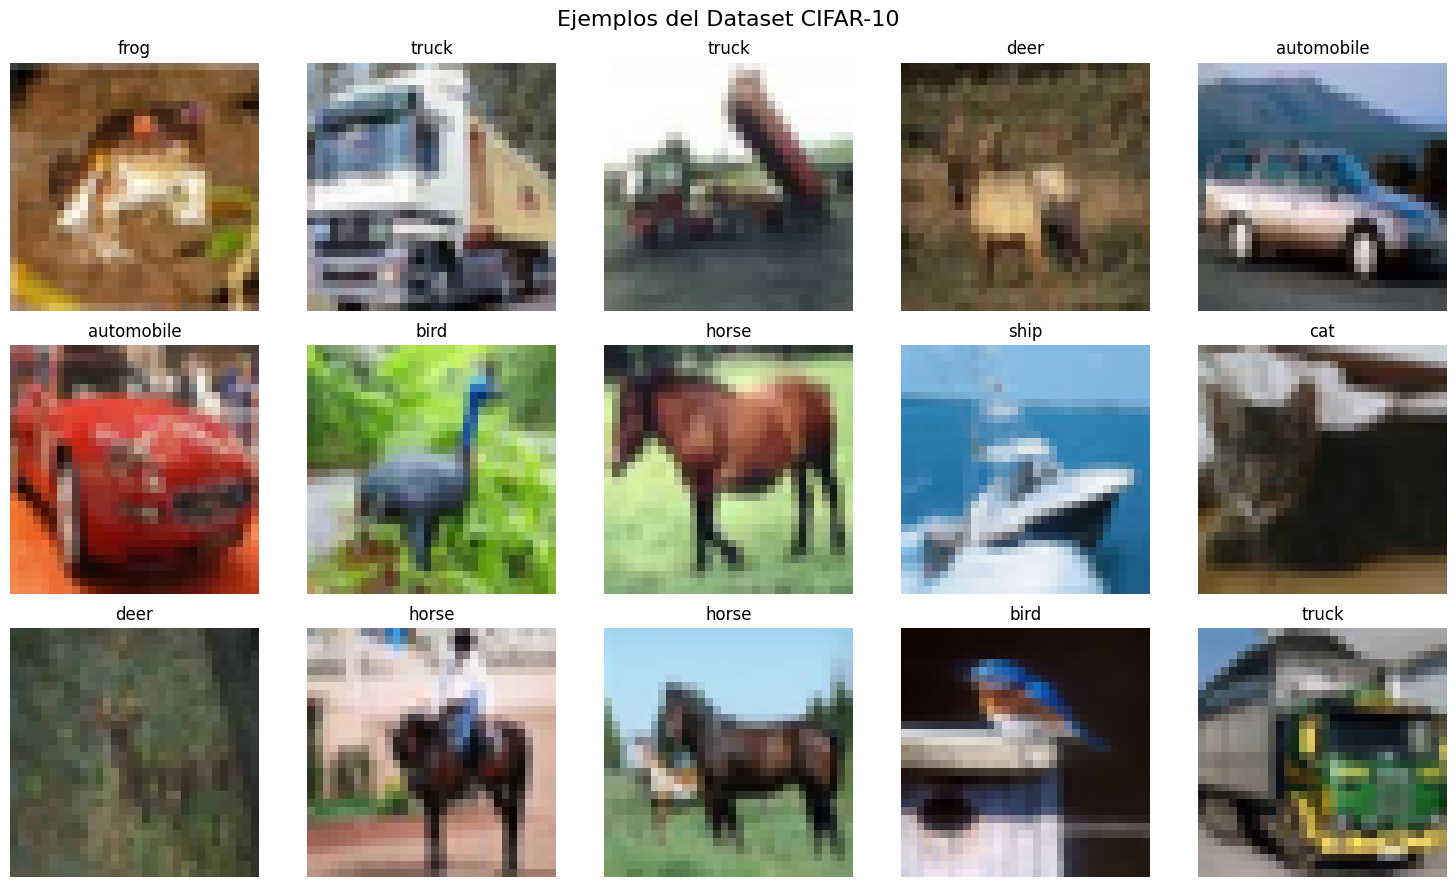

In [14]:
# Visualizar algunos ejemplos del dataset
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(f'{class_names[y_train[i][0]]}')
    ax.axis('off')
plt.suptitle('Ejemplos del Dataset CIFAR-10', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
# Preprocesamiento de datos
def preprocess_data(X_train, y_train, X_test, y_test):
    """
    Normaliza las imágenes y convierte las etiquetas a one-hot encoding.
    """
    # Normalizar píxeles al rango [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # One-hot encoding de las etiquetas
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    return X_train, y_train, X_test, y_test

X_train_processed, y_train_processed, X_test_processed, y_test_processed = preprocess_data(
    X_train, y_train, X_test, y_test
)

print('Preprocesamiento completado:')
print(f'X_train shape: {X_train_processed.shape}')
print(f'y_train shape: {y_train_processed.shape}')
print(f'Rango de píxeles normalizados: [{X_train_processed.min():.2f}, {X_train_processed.max():.2f}]')

Preprocesamiento completado:
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
Rango de píxeles normalizados: [0.00, 1.00]


### Función Builder de CNN Flexible

In [16]:
def build_cnn(input_shape=(32, 32, 3), num_classes=10, conv_layers=None, 
              dense_layers=[128], dropout_rate=0.0, use_batch_norm=False,
              l2_reg=0.0):
    """
    Construye una CNN flexible.
    
    Args:
        input_shape: Forma de la imagen de entrada
        num_classes: Número de clases
        conv_layers: Lista de diccionarios con configuración de capas convolucionales
                     Ejemplo: [{'filters': 32, 'kernel_size': 3, 'pool_size': 2}]
        dense_layers: Lista con número de neuronas en capas densas
        dropout_rate: Tasa de dropout (0 = sin dropout)
        use_batch_norm: Si usar batch normalization
        l2_reg: Factor de regularización L2
    
    Returns:
        Modelo de Keras compilado
    """
    if conv_layers is None:
        conv_layers = [
            {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
            {'filters': 64, 'kernel_size': 3, 'pool_size': 2}
        ]
    
    regularizer = keras.regularizers.l2(l2_reg) if l2_reg > 0 else None
    
    model = models.Sequential()
    
    # Primera capa convolucional
    model.add(layers.Input(shape=input_shape))
    
    # Capas convolucionales
    for i, conv_config in enumerate(conv_layers):
        model.add(layers.Conv2D(
            filters=conv_config['filters'],
            kernel_size=conv_config['kernel_size'],
            padding='same',
            activation='relu',
            kernel_regularizer=regularizer,
            name=f'conv_{i+1}'
        ))
        
        if use_batch_norm:
            model.add(layers.BatchNormalization())
        
        if 'pool_size' in conv_config:
            model.add(layers.MaxPooling2D(
                pool_size=conv_config['pool_size'],
                name=f'pool_{i+1}'
            ))
        
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    
    # Aplanar
    model.add(layers.Flatten())
    
    # Capas densas
    for i, units in enumerate(dense_layers):
        model.add(layers.Dense(
            units, 
            activation='relu',
            kernel_regularizer=regularizer,
            name=f'dense_{i+1}'
        ))
        
        if use_batch_norm:
            model.add(layers.BatchNormalization())
        
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    
    # Capa de salida
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))
    
    return model

print('Función build_cnn definida correctamente')

Función build_cnn definida correctamente


### Funciones de Entrenamiento y Visualización

In [17]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, 
                       epochs=20, batch_size=64, learning_rate=0.001,
                       experiment_name="Experimento", use_data_augmentation=False):
    """
    Entrena y evalúa un modelo CNN.
    
    Args:
        model: Modelo de Keras
        X_train, y_train: Datos de entrenamiento
        X_test, y_test: Datos de prueba
        epochs: Número de épocas
        batch_size: Tamaño del batch
        learning_rate: Tasa de aprendizaje
        experiment_name: Nombre del experimento
        use_data_augmentation: Si usar data augmentation
    
    Returns:
        Diccionario con resultados y historia del entrenamiento
    """
    print(f"\n{'='*70}")
    print(f"{experiment_name}")
    print(f"{'='*70}\n")
    
    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Mostrar arquitectura
    print("Arquitectura del modelo:")
    model.summary()
    
    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=0
        )
    ]
    
    # Data augmentation si está activado
    if use_data_augmentation:
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
        datagen.fit(X_train)
        print("\n[INFO] Usando Data Augmentation")

    # Entrenamiento
    print("\nIniciando entrenamiento...\n")
    start_time = time()

    if use_data_augmentation:
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
    else:
        history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
    
    training_time = time() - start_time
    
    # Evaluación final
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\n{'='*70}")
    print(f"Resultados Finales:")
    print(f"  Tiempo de entrenamiento: {training_time:.2f} segundos")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc*100:.2f}%")
    print(f"{'='*70}\n")
    
    # Visualización
    plot_training_history(history, experiment_name)
    
    return {
        'history': history.history,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'training_time': training_time,
        'epochs_trained': len(history.history['loss'])
    }


def plot_training_history(history, title="Training History"):
    """
    Visualiza la historia del entrenamiento.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    ax1.plot(history.history['loss'], label='Train Loss', marker='o', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    ax1.set_xlabel('Época', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Pérdida durante el Entrenamiento', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Accuracy
    ax2.plot(history.history['accuracy'], label='Train Accuracy', marker='o', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s', linewidth=2)
    ax2.set_xlabel('Época', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Precisión durante el Entrenamiento', fontsize=14)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

print('Funciones de entrenamiento y visualización definidas correctamente')

Funciones de entrenamiento y visualización definidas correctamente


---
---
# EJERCICIOS

A continuación se presentan 10 ejercicios donde deberás completar partes del código, modificar arquitecturas y analizar resultados.

---
## Ejercicio 1: CNN Baseline Simple

**Objetivo**: Construir y entrenar una CNN básica de 2 capas convolucionales para establecer un baseline.

**Configuración ya dada**:
- 2 bloques convolucionales con 32 y 64 filtros
- Kernel size 3x3, MaxPooling 2x2
- 1 capa densa de 128 neuronas
- 20 épocas, batch_size=64, learning_rate=0.001


Ejercicio 1: CNN Baseline Simple

Arquitectura del modelo:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4752 - loss: 1.4599 - val_accuracy: 0.5807 - val_loss: 1.1759
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6139 - loss: 1.0931 - val_accuracy: 0.6377 - val_loss: 1.0270
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6674 - loss: 0.9474 - val_accuracy: 0.6647 - val_loss: 0.9585
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7002 - loss: 0.8589 - val_accuracy: 0.6760 - val_loss: 0.9389
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7276 - loss: 0.7846 - val_accuracy: 0.6795 - val_loss: 0.9433
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7496 - loss: 0.7221 - val_accuracy: 0.6824 - val_loss: 0.9516
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7722 - loss: 0.6624 - val_accuracy: 0.6849 - val_loss: 0.9744
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7899 - l

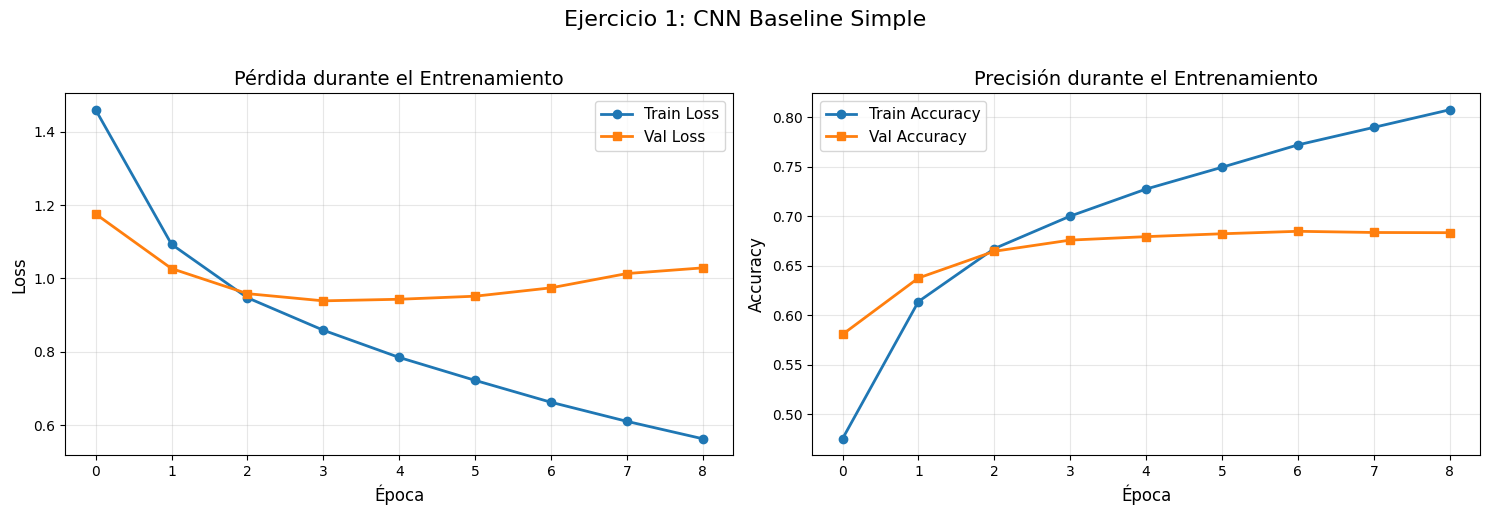

In [18]:
# Ejercicio 1: CNN Baseline
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2}
]

model_ex1 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=False
)

results_ex1 = train_and_evaluate(
    model_ex1,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 1: CNN Baseline Simple"
)

### Respuestas Ejercicio 1

**1.1** ¿Cuál fue la exactitud final en el conjunto de test?

67.60%

**1.2** ¿Observas overfitting? ¿Cómo lo identificas en las gráficas?

Sí, la exactitud con los datos de entrenamiento mejoran, mientras que con los datos de validación se estanca e incluso comienza a empeorar al final.

**1.3** ¿Cuántas épocas tomó antes de que el early stopping detuviera el entrenamiento (si aplica)?

El entrenamiento se detuvo a las 9 épocas debido al "early stopping".

---
## Ejercicio 2: Agregar una Tercera Capa Convolucional

**Objetivo**: Explorar el efecto de hacer la red más profunda.

**TAREA**: Completa el código agregando una tercera capa convolucional con:
- **128 filtros**
- **Kernel size de 3x3**
- **MaxPooling de 2x2**

**Pregunta**: ¿Una red más profunda mejora automáticamente los resultados?


Ejercicio 2: CNN con 3 Capas Convolucionales

Arquitectura del modelo:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4735 - loss: 1.4546 - val_accuracy: 0.6024 - val_loss: 1.1264
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6362 - loss: 1.0328 - val_accuracy: 0.6715 - val_loss: 0.9355
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6992 - loss: 0.8634 - val_accuracy: 0.6999 - val_loss: 0.8566
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7421 - loss: 0.7433 - val_accuracy: 0.7024 - val_loss: 0.8651
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7719 - loss: 0.6569 - val_accuracy: 0.7012 - val_loss: 0.8759
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7990 - loss: 0.5817 - val_accuracy: 0.7103 - val_loss: 0.8713
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8212 - loss: 0.5111 - val_accuracy: 0.7142 - val_loss: 0.8936
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8

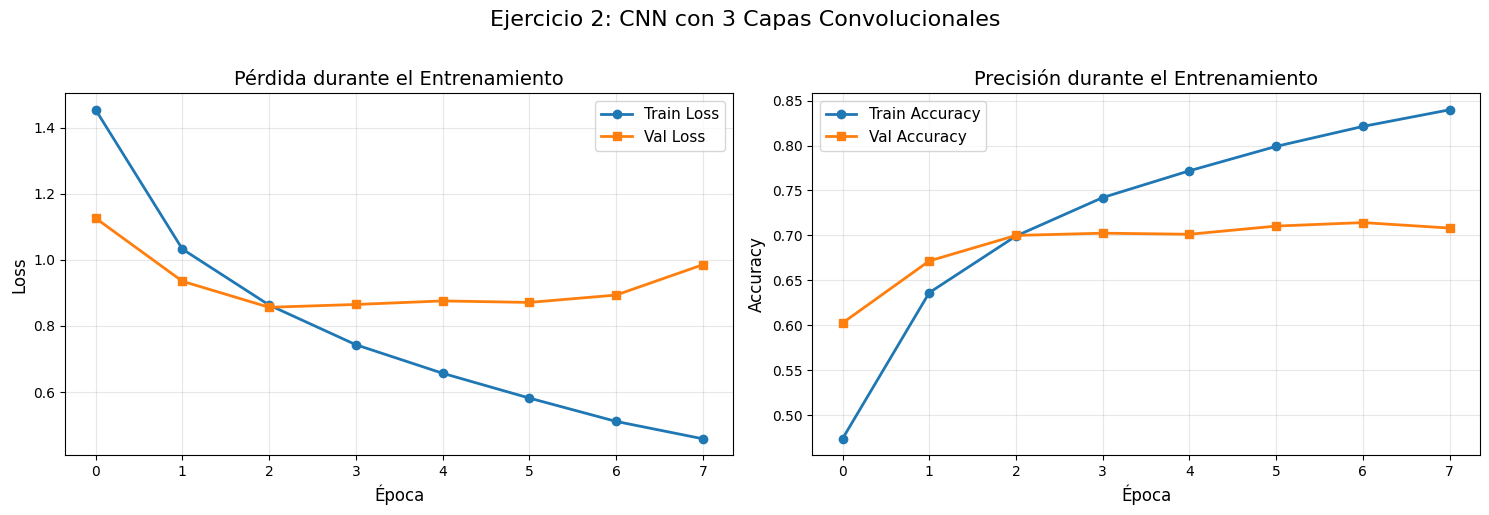

In [19]:
# Ejercicio 2: Agregar tercera capa convolucional

conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

model_ex2 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=False
)

results_ex2 = train_and_evaluate(
    model_ex2,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 2: CNN con 3 Capas Convolucionales"
)

### Respuestas Ejercicio 2

**2.1** ¿Mejoró la exactitud comparada con el baseline?

Muy poco, solo 2.39%.

**2.2** ¿El tiempo de entrenamiento aumentó significativamente?

Sí, aumento 11.38 segundos. Y solo se entrenó por 8 épocas.

**2.3** ¿Hay más o menos overfitting que en el Ejercicio 1?

El overfitting es similar al del ejercicio 1.

---
## Ejercicio 3: Implementar Dropout

**Objetivo**: Usar dropout como técnica de regularización para reducir overfitting.

**TAREA**: El código ya está casi completo. Debes cambiar el parámetro `dropout_rate` de 0.0 a **0.5**

**Pregunta**: ¿Cómo afecta el dropout al overfitting y a la exactitud en entrenamiento vs test?


Ejercicio 3: CNN con Dropout (0.5)

Arquitectura del modelo:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3029 - loss: 1.8722 - val_accuracy: 0.4372 - val_loss: 1.6137
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4290 - loss: 1.5667 - val_accuracy: 0.4959 - val_loss: 1.4272
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4752 - loss: 1.4481 - val_accuracy: 0.5253 - val_loss: 1.3318
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5032 - loss: 1.3767 - val_accuracy: 0.5471 - val_loss: 1.2619
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5252 - loss: 1.3219 - val_accuracy: 0.5441 - val_loss: 1.2454
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5407 - loss: 1.2839 - val_accuracy: 0.6047 - val_loss: 1.1070
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5567 - loss: 1.2523 - val_accuracy: 0.5939 - val_loss: 1.1339
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 

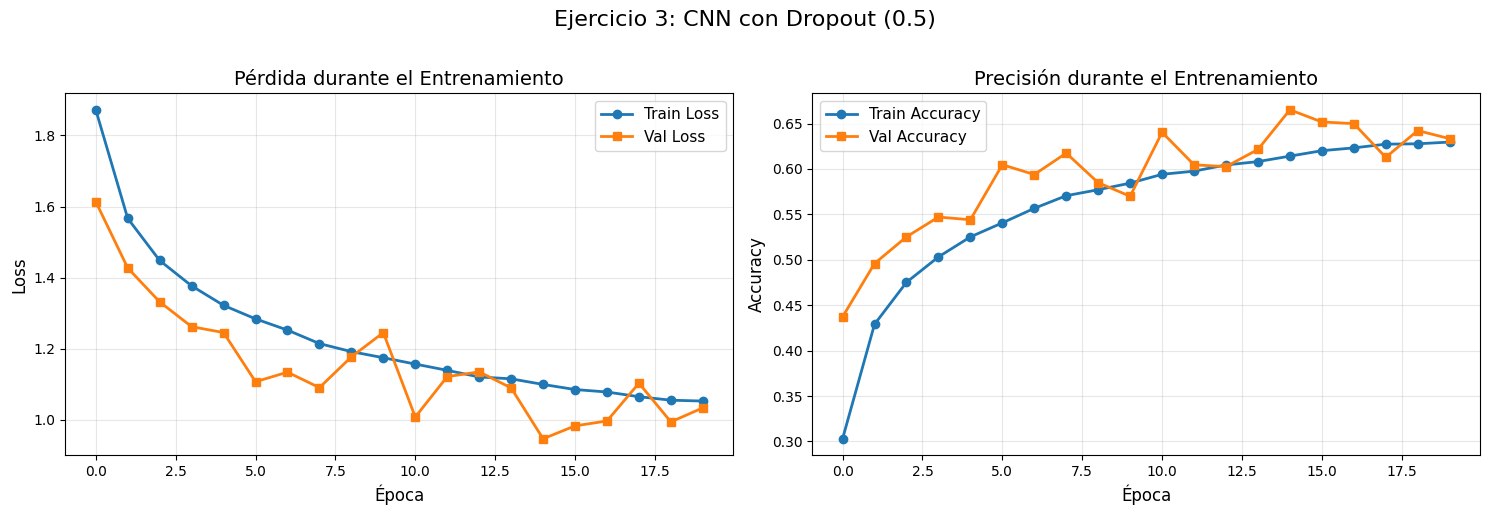

In [26]:
# Ejercicio 3: Implementar Dropout
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

model_ex3 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.5,
    use_batch_norm=False
)

results_ex3 = train_and_evaluate(
    model_ex3,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 3: CNN con Dropout (0.5)"
)

### Respuestas Ejercicio 3

**3.1** ¿Se redujo la brecha entre train accuracy y val accuracy?

Sí, la brecha se redujo.

**3.2** ¿La exactitud en test mejoró o empeoró comparada con el Ejercicio 2?

Empeoró de 69.99% a 66.52%.

**3.3** ¿En qué momento del entrenamiento es más visible el efecto del dropout?

En la primera época se puede observar que la exactitud del conjunto de entrenamiento yá es menor que para el conjunto de validación.
Luego, en épocas posteriores, la brecha se reduce en ciertos puntos, pero es bastante inestable.

---
## Ejercicio 4: Batch Normalization

**Objetivo**: Implementar batch normalization para mejorar la estabilidad del entrenamiento.

**TAREA**: Activa batch normalization cambiando `use_batch_norm` de False a **True**

**Pregunta**: ¿Cómo afecta la batch normalization a la velocidad de convergencia?


Ejercicio 4: CNN con Batch Normalization

Arquitectura del modelo:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,218 (1.37 MB)

 Trainable params: 357,514 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5858 - loss: 1.1761 - val_accuracy: 0.6169 - val_loss: 1.0731
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7152 - loss: 0.8118 - val_accuracy: 0.6655 - val_loss: 0.9903
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7760 - loss: 0.6424 - val_accuracy: 0.6877 - val_loss: 0.9384
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8210 - loss: 0.5148 - val_accuracy: 0.6307 - val_loss: 1.2124
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8590 - loss: 0.4099 - val_accuracy: 0.6965 - val_loss: 1.0177
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8911 - loss: 0.3146 - val_accuracy: 0.6821 - val_loss: 1.1857
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9176 - loss: 0.2427 - val_accuracy: 0.6859 - val_loss: 1.2996
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accur

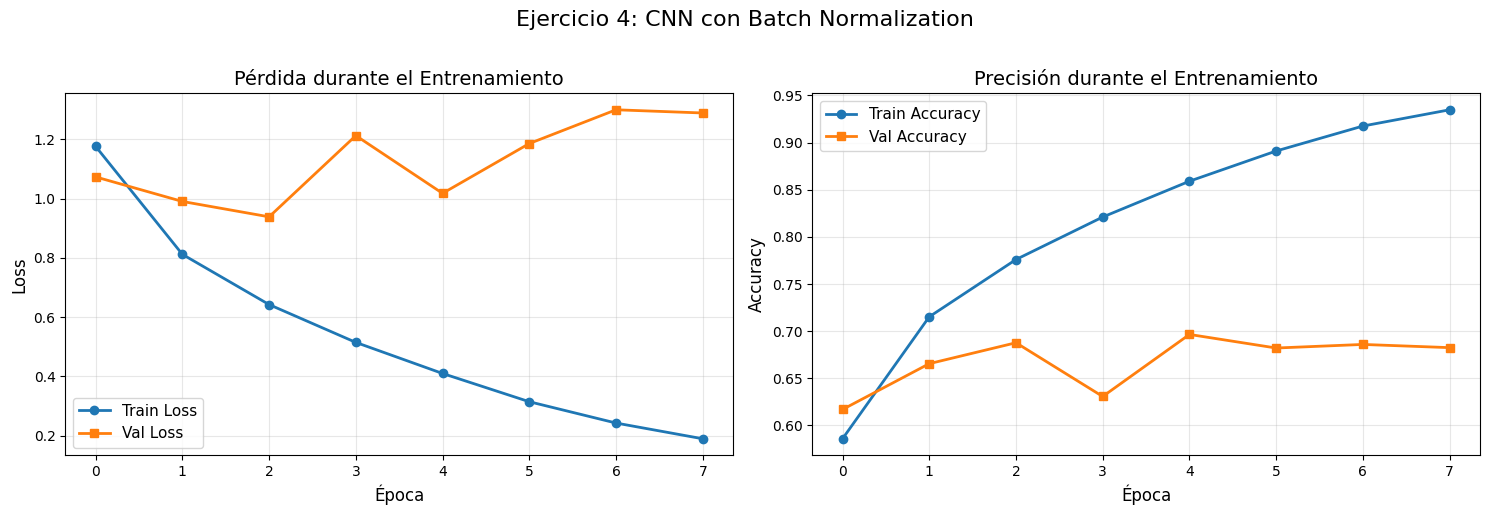

In [27]:
# Ejercicio 4: Batch Normalization
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

model_ex4 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=True
)

results_ex4 = train_and_evaluate(
    model_ex4,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 4: CNN con Batch Normalization"
)

### Respuestas Ejercicio 4

**4.1** ¿La red converge más rápido con batch normalization?

Sí, para el conjunto de entrenamiento, la exactitud llegó a 93% en la época 8.
Aunque aún hay overfitting.

**4.2** ¿Cómo se compara la exactitud final con los ejercicios anteriores?

- Test Accuracy 1: 67.60%
- Test Accuracy 2: 69.99%
- Test Accuracy 3: 66.52%
- Test Accuracy 4: 68.77%

No hay mucha diferencia respecto a las anteriores.

**4.3** ¿Las curvas de loss son más suaves?

Solo parecen ser un poco más suaves que en el ejercicio anterior, pero no que 1 y el 2.

---
## Ejercicio 5: Aumentar el Learning Rate

**Objetivo**: Experimentar con un learning rate más alto.

**Configuración**: Usa el modelo del Ejercicio 4 (con batch norm) pero con learning_rate=0.01 (10x más alto)

**Pregunta**: ¿Cómo afecta un learning rate alto cuando se usa batch normalization?


Ejercicio 5: Learning Rate Alto (0.01) + Batch Norm

Arquitectura del modelo:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,218 (1.37 MB)

 Trainable params: 357,514 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5510 - loss: 1.2647 - val_accuracy: 0.5756 - val_loss: 1.2807
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6900 - loss: 0.8802 - val_accuracy: 0.6385 - val_loss: 1.1113
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7454 - loss: 0.7236 - val_accuracy: 0.6703 - val_loss: 0.9805
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7883 - loss: 0.6042 - val_accuracy: 0.6630 - val_loss: 1.0782
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8245 - loss: 0.5018 - val_accuracy: 0.6740 - val_loss: 1.2078
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8508 - loss: 0.4207 - val_accuracy: 0.6530 - val_loss: 1.3878
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8748 - loss: 0.3487 - val_accuracy: 0.6454 - val_loss: 1.5477
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accur

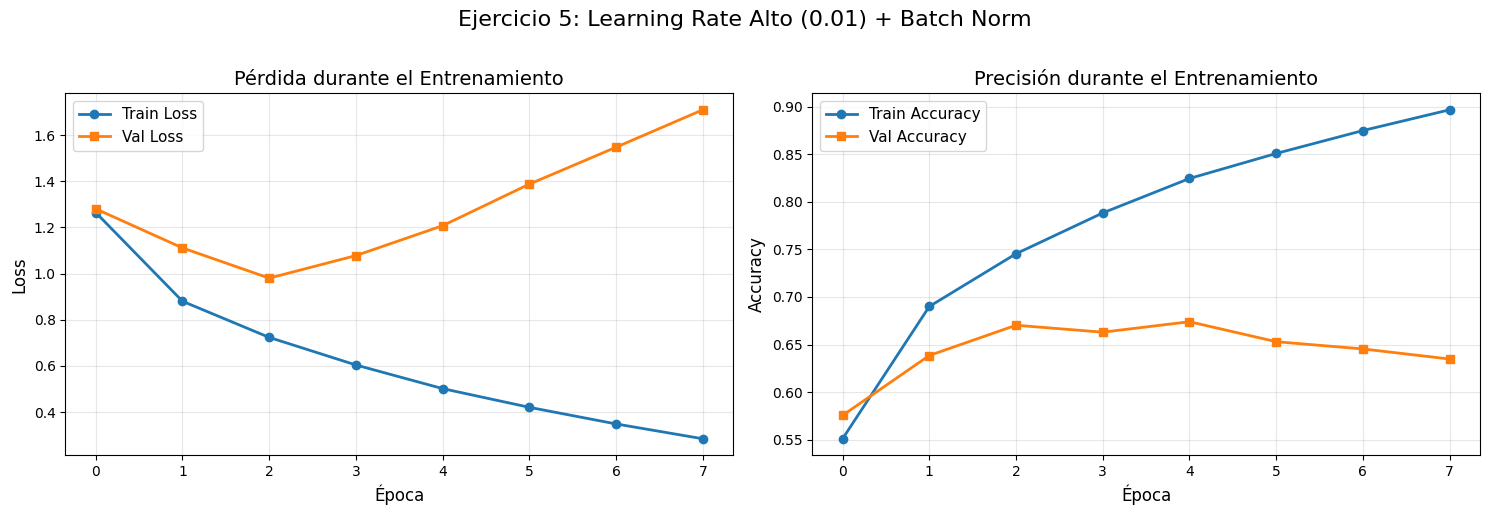

In [22]:
# Ejercicio 5: Learning Rate Alto con Batch Normalization
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

model_ex5 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=True
)

results_ex5 = train_and_evaluate(
    model_ex5,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.01,  # 10x más alto
    experiment_name="Ejercicio 5: Learning Rate Alto (0.01) + Batch Norm"
)

### Respuestas Ejercicio 5

**5.1** ¿El entrenamiento es estable con este learning rate?

Para el conjunto de entrenamiento, parece mantener la misma estabilidad que el anterior.
Pero, si parece ser más estable para el conjunto de validación.

**5.2** ¿La convergencia es más rápida comparada con learning_rate=0.001?

- Ejercicio 4: 0.9348 train accuracy (8 épocas)
- Ejercicio 5: 0.8967 train accuracy (8 épocas)

Si comparamos con el modelo anterior, no convergió más rápido.

**5.3** ¿Por qué batch normalization permite usar learning rates más altos?

"batch normalization" suaviza el espacio de la función de perdida, lo cual evita la inestabilidad (divergencia).

---
## Ejercicio 6: Data Augmentation

**Objetivo**: Implementar data augmentation para mejorar la generalización.

**Configuración**: Usa una CNN simple con data augmentation activado.

**Pregunta**: ¿Cómo ayuda el data augmentation a reducir el overfitting?


Ejercicio 6: Data Augmentation

Arquitectura del modelo:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)


[INFO] Usando Data Augmentation

Iniciando entrenamiento...

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4196 - loss: 1.5971 - val_accuracy: 0.5547 - val_loss: 1.2333
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5620 - loss: 1.2354 - val_accuracy: 0.6228 - val_loss: 1.0635
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6151 - loss: 1.0894 - val_accuracy: 0.6705 - val_loss: 0.9389
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6505 - loss: 0.9947 - val_accuracy: 0.6927 - val_loss: 0.8781
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6697 - loss: 0.9381 - val_accuracy: 0.6763 - val_loss: 0.9328
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.6922 - loss: 0.8791 - val_accuracy: 0.7145 - val_loss: 0.8275
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7038 - loss: 0.8426 - val_accuracy: 0.7177 - val_loss: 0.8219
Epoch 8/30
782/782 ━━━━━━━━━

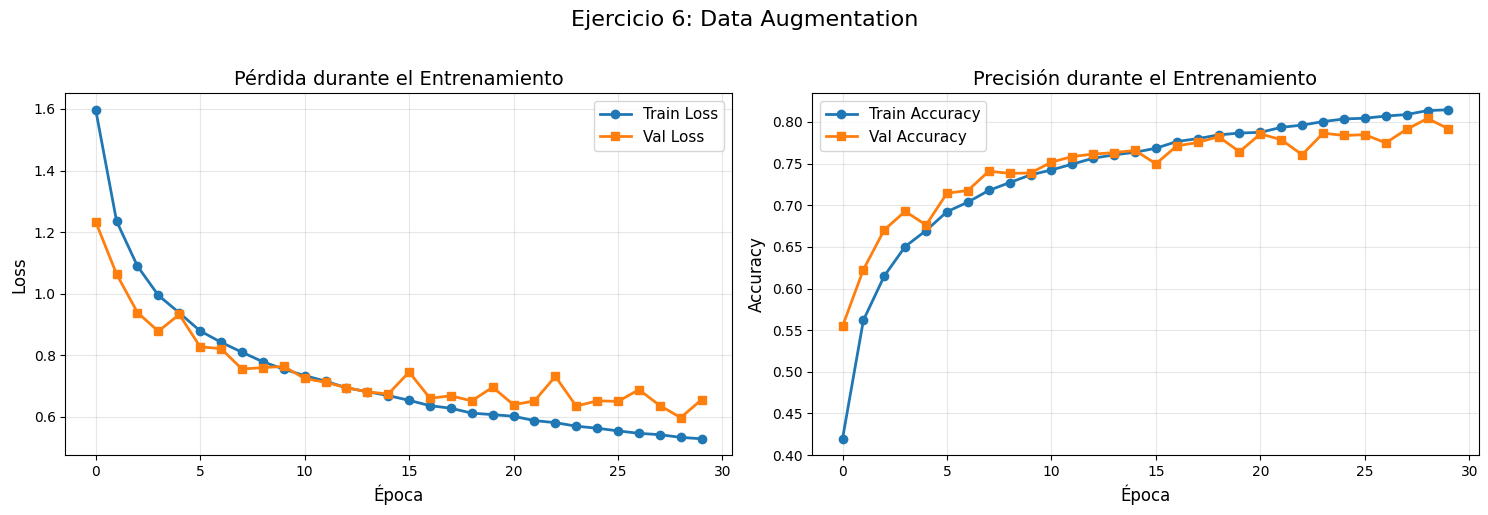

In [23]:
# Ejercicio 6: Data Augmentation
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

model_ex6 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=False
)

results_ex6 = train_and_evaluate(
    model_ex6,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=30,  # Más épocas porque data augmentation requiere más tiempo
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 6: Data Augmentation",
    use_data_augmentation=True  # ACTIVADO
)

### Respuestas Ejercicio 6

**6.1** ¿La exactitud en training es más baja con data augmentation? ¿Por qué?

Sí, porque al entrenar se están generando datos nuevos que no son parte de los datos de entrenamiento.
Al introducir estos datos nuevos generados, el modelo se vuelve "más general", y reduce el "overfitting".

**6.2** ¿Mejoró la exactitud en el conjunto de test?

Sí.

- Test Accuracy 5: 67.03%
- Test Accuracy 6: 80.42%

**6.3** ¿El overfitting se redujo?

Sí.  "Data Augmentation" parece funcionar muy bien para reducir el overfitting.

---
## Ejercicio 7: Regularización L2

**Objetivo**: Explorar la regularización L2 (weight decay) en las capas convolucionales.

**TAREA**: Agrega regularización L2 modificando el parámetro `l2_reg` a **0.001**

**Pregunta**: ¿Cómo compara la regularización L2 con dropout?


Ejercicio 7: Regularización L2 (0.001)

Arquitectura del modelo:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4491 - loss: 1.6555 - val_accuracy: 0.5567 - val_loss: 1.3742
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5925 - loss: 1.3103 - val_accuracy: 0.6407 - val_loss: 1.2080
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6522 - loss: 1.1793 - val_accuracy: 0.6784 - val_loss: 1.1251
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6892 - loss: 1.0995 - val_accuracy: 0.6980 - val_loss: 1.0825
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7119 - loss: 1.0462 - val_accuracy: 0.7118 - val_loss: 1.0657
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7300 - loss: 1.0079 - val_accuracy: 0.7138 - val_loss: 1.0604
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7436 - loss: 0.9780 - val_accuracy: 0.7193 - val_loss: 1.0689
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7

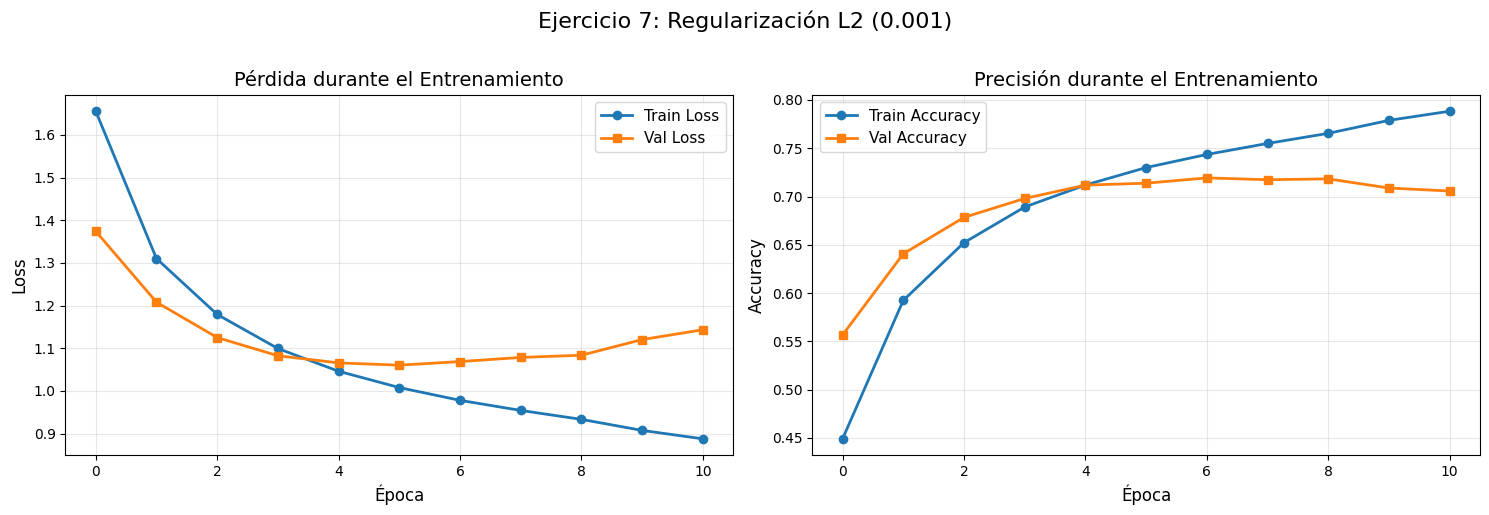

In [28]:
# Ejercicio 7: Regularización L2
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

model_ex7 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=False,
    l2_reg=0.001
)

results_ex7 = train_and_evaluate(
    model_ex7,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 7: Regularización L2 (0.001)"
)

### Respuestas Ejercicio 7

**7.1** ¿El overfitting se redujo con L2 regularization?

No, el overfitting parece empeorar conforme avanza el entrenamiento a partir de la epoca 5.

**7.2** Compara el efecto con el dropout (Ejercicio 3). ¿Cuál funciona mejor?

Con respecto a exactitud en la validación, L2 parece ser mejor.
Pero no mejora respecto al "overfitting".

**7.3** ¿Puedes usar dropout y L2 juntos?

Sí, son dos estrategias complementarias para evitar el overfitting.
Aunque se debe tener cuidado de no usar valores muy altos que restrinjan el aprendizaje (underfitting).

---
## Ejercicio 8: Arquitectura Más Ancha

**Objetivo**: Experimentar con más filtros en cada capa (red más ancha).

**TAREA**: Modifica la configuración para usar 64, 128, 256 filtros respectivamente

**Pregunta**: ¿Es mejor tener más filtros (red ancha) o más capas (red profunda)?


Ejercicio 8: Arquitectura Más Ancha [64, 128, 256]

Arquitectura del modelo:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425,034 (5.44 MB)

 Trainable params: 1,423,626 (5.43 MB)

 Non-trainable params: 1,408 (5.50 KB)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.4910 - loss: 1.4711 - val_accuracy: 0.5868 - val_loss: 1.1493
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.6374 - loss: 1.0257 - val_accuracy: 0.6026 - val_loss: 1.1504
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.6957 - loss: 0.8651 - val_accuracy: 0.5184 - val_loss: 1.5946
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.7263 - loss: 0.7732 - val_accuracy: 0.6613 - val_loss: 1.0353
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.7518 - loss: 0.7048 - val_accuracy: 0.6299 - val_loss: 1.1610
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.7731 - loss: 0.6436 - val_accuracy: 0.6904 - val_loss: 0.9533
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.7886 - loss: 0.5997 - val_accuracy: 0.7174 - val_loss: 0.8126
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accur

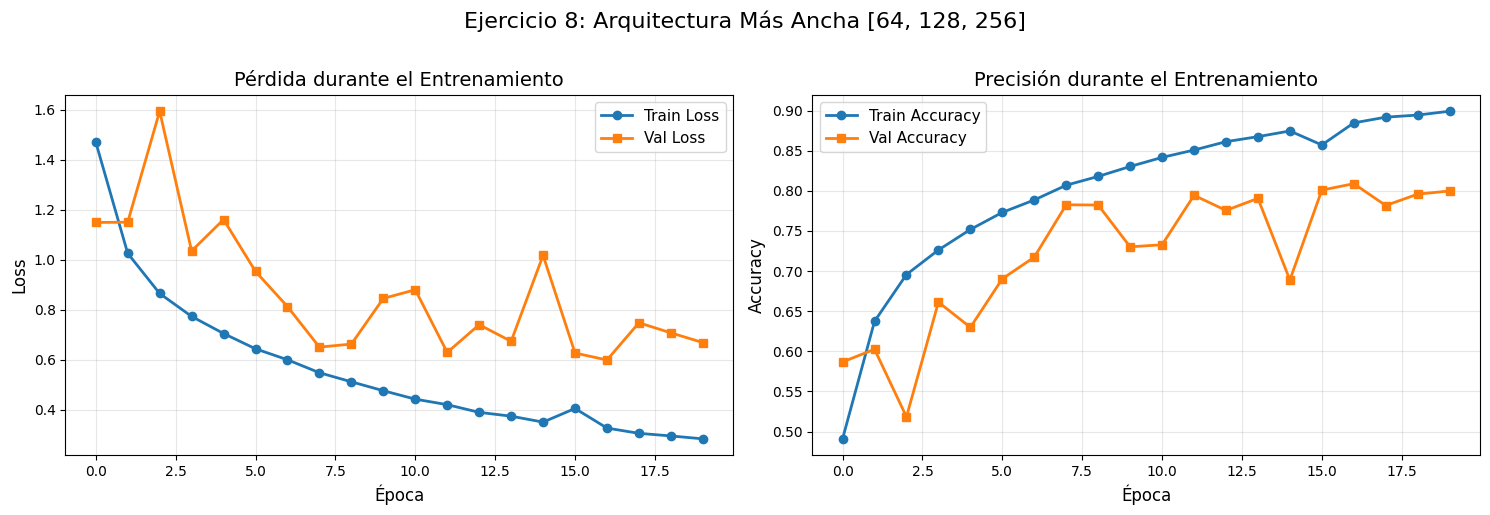

In [29]:
# Ejercicio 8: Arquitectura Más Ancha

conv_config = [
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 256, 'kernel_size': 3, 'pool_size': 2}
]

model_ex8 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[256],  # También hacemos más ancha la capa densa
    dropout_rate=0.3,
    use_batch_norm=True
)

results_ex8 = train_and_evaluate(
    model_ex8,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 8: Arquitectura Más Ancha [64, 128, 256]"
)

### Respuestas Ejercicio 8

**8.1** ¿Mejoró la exactitud con una red más ancha?

Sí, mejoro la exactitud, pero el entrenamiento tomo mucho más tiempo.

**8.2** ¿Cuánto aumentó el tiempo de entrenamiento?

- Ejercicio 3: 188 segundos.
- Ejercicio 8: 666 segundos.

Un aumento de 3.5x respecto a un ejercicio anterior con una configuración similar, pero menos ancha.

**8.3** ¿Vale la pena el costo computacional adicional?

Sí poseemos los recursos, creo que si vale la pena.

---
## Ejercicio 9: Reducir Batch Size

**Objetivo**: Explorar el efecto de un batch size pequeño.

**Configuración**: Usa batch_size=16 en lugar de 64

**Pregunta**: ¿Cómo afecta el batch size al gradiente y a la convergencia?


Ejercicio 9: Batch Size Pequeño (16)

Arquitectura del modelo:


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,218 (1.37 MB)

 Trainable params: 357,514 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)


Iniciando entrenamiento...

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.4707 - loss: 1.5042 - val_accuracy: 0.6187 - val_loss: 1.0755
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.5878 - loss: 1.1727 - val_accuracy: 0.4459 - val_loss: 1.7342
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.6340 - loss: 1.0533 - val_accuracy: 0.6002 - val_loss: 1.1814
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.6610 - loss: 0.9765 - val_accuracy: 0.4432 - val_loss: 1.9102
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.6787 - loss: 0.9192 - val_accuracy: 0.6746 - val_loss: 0.9580
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.6972 - loss: 0.8728 - val_accuracy: 0.6787 - val_loss: 0.9591
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7075 - loss: 0.8447 - val_accuracy: 0.5990 - val_loss: 1.2802
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step

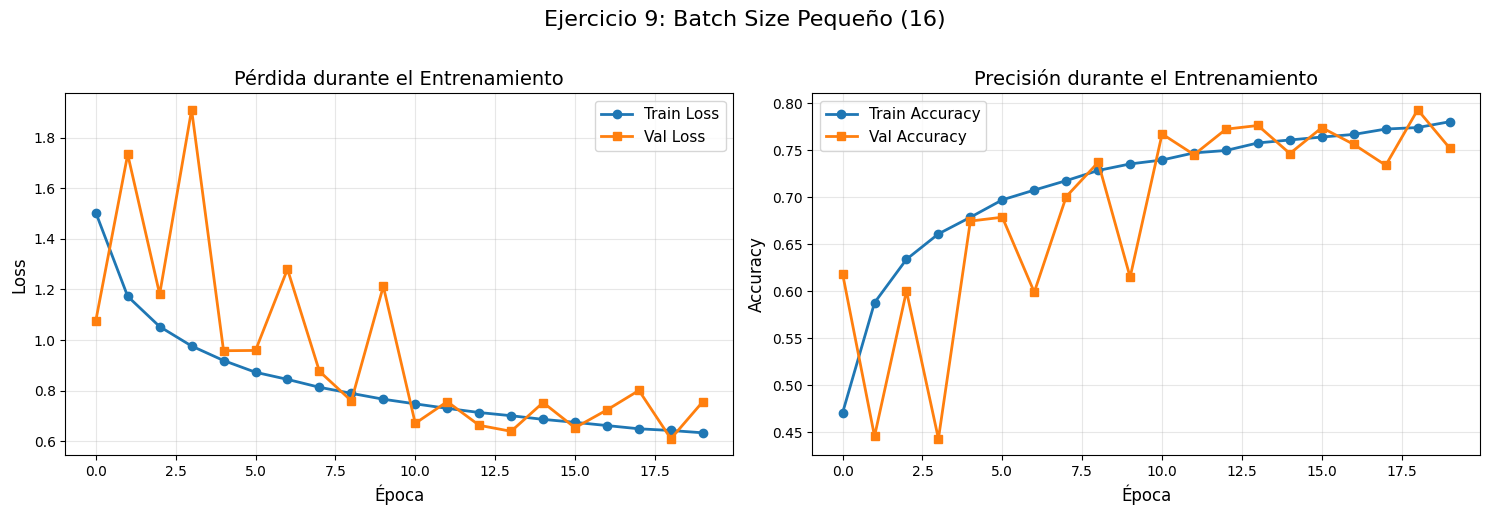

In [30]:
# Ejercicio 9: Batch Size Pequeño
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

model_ex9 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.3,
    use_batch_norm=True
)

results_ex9 = train_and_evaluate(
    model_ex9,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=16,  # Batch size pequeño
    learning_rate=0.001,
    experiment_name="Ejercicio 9: Batch Size Pequeño (16)"
)

### Respuestas Ejercicio 9

**9.1** ¿Las curvas de entrenamiento son más ruidosas?

Sí. Especialmente notable para el conjunto de validación.

**9.2** ¿El tiempo de entrenamiento por época aumentó?

Sí.

- Ejercicio 3: 13 segundos por época.
- Ejercicio 9: 29 segundos por época.

**9.3** ¿Cuál es el trade-off entre batch size pequeño y grande?

Mayor tiempo de entrenamiento, pero el resultado final es mejor.

---
## Ejercicio 10: Modelo Óptimo Combinado

**Objetivo**: Diseñar tu mejor modelo combinando las técnicas más efectivas.

**TAREA**: Diseña la configuración óptima basándote en tus experimentos anteriores. Combina:
- Arquitectura apropiada (número de capas y filtros)
- Técnicas de regularización que funcionaron mejor
- Hiperparámetros óptimos
- Data augmentation si es necesario

**Pregunta**: ¿Puedes superar el 75% de accuracy en test?


Ejercicio 10: Modelo Óptimo

Arquitectura del modelo:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425,034 (5.44 MB)

 Trainable params: 1,423,626 (5.43 MB)

 Non-trainable params: 1,408 (5.50 KB)


[INFO] Usando Data Augmentation

Iniciando entrenamiento...

Epoch 1/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - accuracy: 0.4554 - loss: 1.5469 - val_accuracy: 0.5376 - val_loss: 1.3035
Epoch 2/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.5767 - loss: 1.2009 - val_accuracy: 0.6675 - val_loss: 0.9492
Epoch 3/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.6148 - loss: 1.1047 - val_accuracy: 0.6981 - val_loss: 0.8596
Epoch 4/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.6476 - loss: 1.0115 - val_accuracy: 0.6682 - val_loss: 0.9383
Epoch 5/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.6650 - loss: 0.9561 - val_accuracy: 0.6955 - val_loss: 0.8991
Epoch 6/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.6812 - loss: 0.9143 - val_accuracy: 0.7257 - val_loss: 0.7951
Epoch 7/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.6954 - loss: 0.8735 - val_accuracy: 0.7381 - val_loss: 0.7529
Epoch 8/30
312

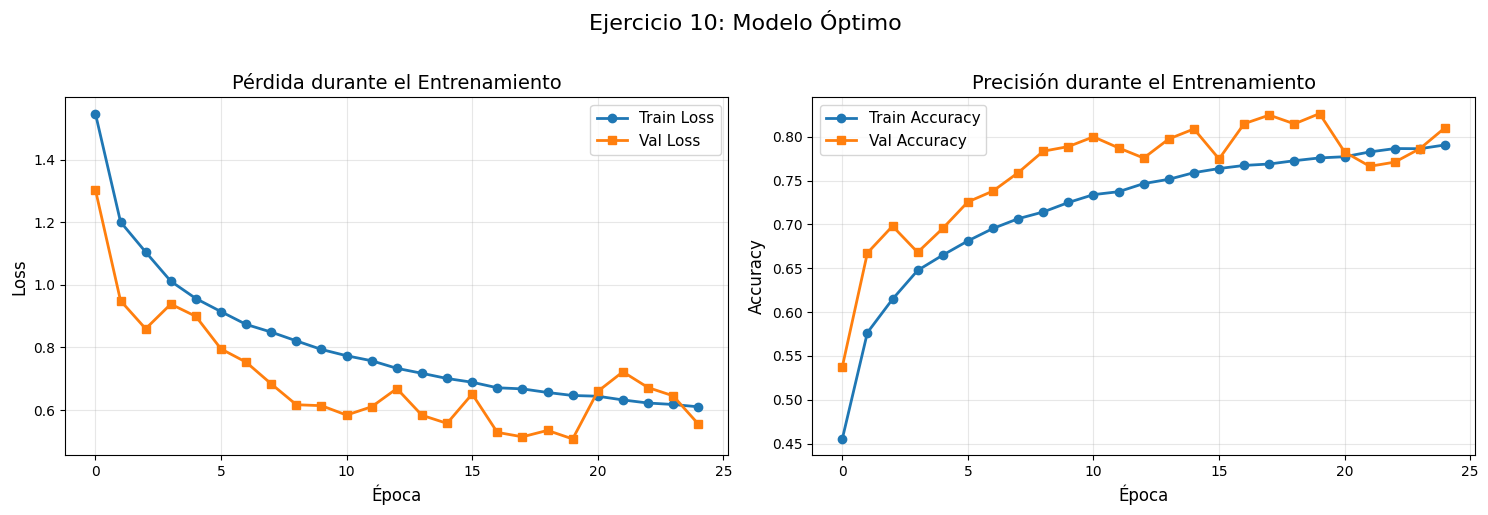

In [32]:
# Ejercicio 10: Modelo Óptimo

conv_config = [
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 256, 'kernel_size': 3, 'pool_size': 2}
]

model_ex10 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[256],
    dropout_rate=0.2,
    use_batch_norm=True,
    l2_reg=0.0
)

results_ex10 = train_and_evaluate(
    model_ex10,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=30,
    batch_size=16,
    learning_rate=0.001,
    experiment_name="Ejercicio 10: Modelo Óptimo",
    use_data_augmentation=True
)

### Respuestas Ejercicio 10

**10.1** Describe detalladamente tu configuración óptima y justifica cada decisión:

- **Arquitectura (capas y filtros)**: Wide 64, 128, 256

Esta arquitectura obtuvo los mejores resultados, asi que decidí replicarla.

- **Dropout rate**: 0.2

Para reducir el overfitting, aunque preferí usar un valor más pequeño para reducir la inestabilidad.

- **Batch Normalization**: True

Parece ayudar con la convergencia durante el entrenamiento.

- **L2 Regularization**: No

No me funciono muy bien en conjunto con Batch Normalization y Dropout rate, así que lo desactive.

- **Learning rate**: 0.001

Por ninguna razón en especial, aparte de que funcionó bien en los ejercicios anteriores.
Y no tengo mucho tiempo para experimentar con este valor.

- **Batch size**: 16

Los resultados del ejercicio 9 también mostraron que este batch size produce mejores resultados para este tipo de modelo y datos.
Así que me parecio buena idea replicarlo.

- **Data Augmentation**: True

Las mejoras en los resultados al activar "Data Augmentation" esto fueron muy buenas, y reduce el overfitting enormemente.
En general, este concepto me parece una muy buena forma de diversificar los datos de entrenamiento.

**10.2** ¿Cuál fue tu mejor exactitud en test?

82.64%

**10.3** ¿Qué lecciones clave aprendiste sobre el diseño de CNNs?

Es importante experimentar con diferentes configuraciones.  Aunque realmente el tiempo de entrenamiento largo (más de 10 minutos limito la cantidad de posibles combinaciones con la que pude experimentar).

Idealmente, sería genial poder tener multiples máquinas en paralelo entrenando modelos de prueba para validar las configuraciones.

---
## Comparación Final de Todos los Experimentos


COMPARACIÓN FINAL DE TODOS LOS EXPERIMENTOS
               Experimento Test Accuracy (%) Test Loss  Epochs Tiempo (s)
     Ejercicio 1: Baseline             67.60    0.9389       9      58.82
Ejercicio 2: 3 Conv Layers             69.99    0.8566       8      70.20
      Ejercicio 3: Dropout             66.52    0.9465      20     188.79
   Ejercicio 4: Batch Norm             68.77    0.9384       8     104.48
      Ejercicio 5: High LR             67.03    0.9805       8     105.62
     Ejercicio 6: Data Aug             80.42    0.5978      30     400.75
       Ejercicio 7: L2 Reg             71.38    1.0604      11      90.19
        Ejercicio 8: Wider             80.89    0.5988      20     666.94
  Ejercicio 9: Small Batch             79.29    0.6100      20     566.47
     Ejercicio 10: Optimal             82.64    0.5076      25    1053.27


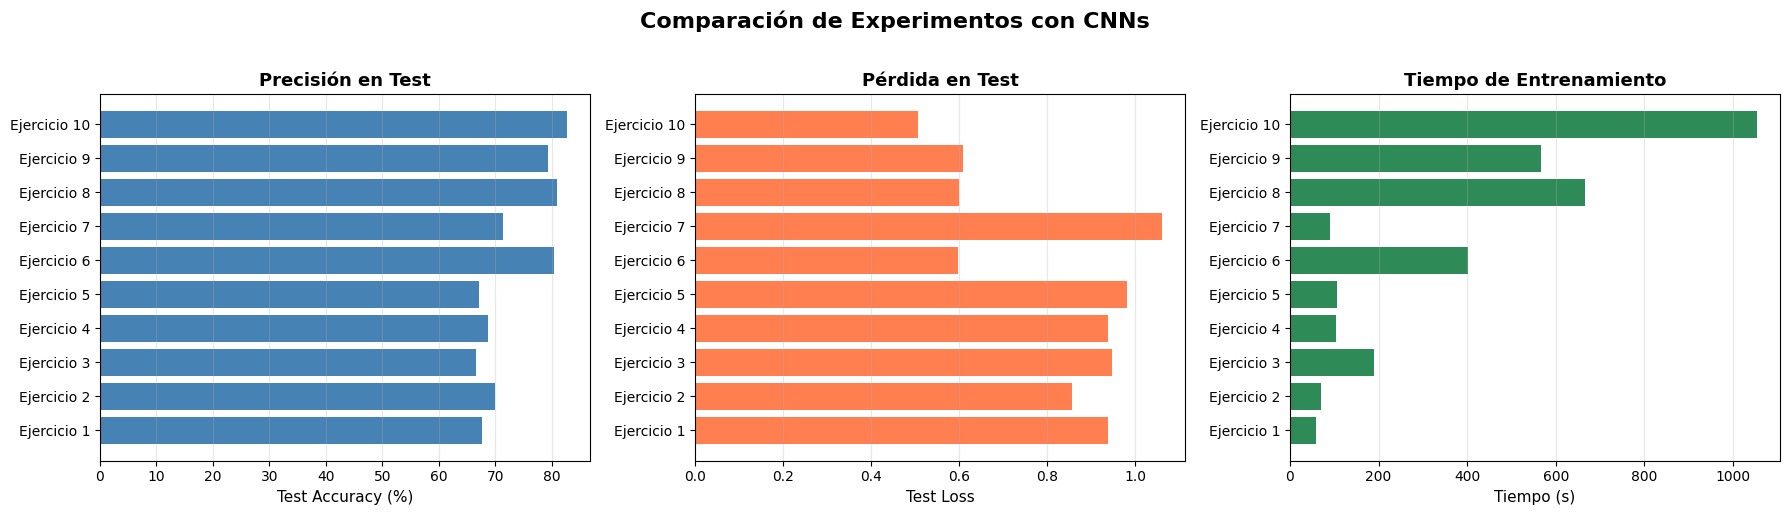


🏆 MEJOR MODELO: Ejercicio 10
   Accuracy: 82.64%
   Loss: 0.5076
   Tiempo: 1053.27s


In [33]:
# Comparación de resultados
import pandas as pd

experiments = {
    'Ejercicio 1: Baseline': results_ex1,
    'Ejercicio 2: 3 Conv Layers': results_ex2,
    'Ejercicio 3: Dropout': results_ex3,
    'Ejercicio 4: Batch Norm': results_ex4,
    'Ejercicio 5: High LR': results_ex5,
    'Ejercicio 6: Data Aug': results_ex6,
    'Ejercicio 7: L2 Reg': results_ex7,
    'Ejercicio 8: Wider': results_ex8,
    'Ejercicio 9: Small Batch': results_ex9,
    'Ejercicio 10: Optimal': results_ex10,
}

# Crear tabla comparativa
comparison_data = []
for name, result in experiments.items():
    comparison_data.append({
        'Experimento': name,
        'Test Accuracy (%)': f"{result['test_acc']*100:.2f}",
        'Test Loss': f"{result['test_loss']:.4f}",
        'Epochs': result['epochs_trained'],
        'Tiempo (s)': f"{result['training_time']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPARACIÓN FINAL DE TODOS LOS EXPERIMENTOS")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

experiment_names = [name.split(':')[0] for name in experiments.keys()]
accuracies = [result['test_acc']*100 for result in experiments.values()]
times = [result['training_time'] for result in experiments.values()]
losses = [result['test_loss'] for result in experiments.values()]

# Accuracy
axes[0].barh(experiment_names, accuracies, color='steelblue')
axes[0].set_xlabel('Test Accuracy (%)', fontsize=11)
axes[0].set_title('Precisión en Test', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Loss
axes[1].barh(experiment_names, losses, color='coral')
axes[1].set_xlabel('Test Loss', fontsize=11)
axes[1].set_title('Pérdida en Test', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Time
axes[2].barh(experiment_names, times, color='seagreen')
axes[2].set_xlabel('Tiempo (s)', fontsize=11)
axes[2].set_title('Tiempo de Entrenamiento', fontsize=13, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.suptitle('Comparación de Experimentos con CNNs', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Encontrar el mejor modelo
best_idx = np.argmax(accuracies)
print(f"\n🏆 MEJOR MODELO: {experiment_names[best_idx]}")
print(f"   Accuracy: {accuracies[best_idx]:.2f}%")
print(f"   Loss: {losses[best_idx]:.4f}")
print(f"   Tiempo: {times[best_idx]:.2f}s")

---
## Conclusiones Generales

**Reflexión Final**: Escribe un análisis de al menos 200 palabras resumiendo:

1. Las técnicas que más impactaron el desempeño de tu CNN

Definitivamente, las que mejor funcionaron son:
- Data Augmentation
- Arquitectura ancha (mas filtros)
- Batch Size más pequeño (16)

2. Los trade-offs entre complejidad del modelo y desempeño

Desafortunadamente, esas mismas tecnicas con mayor impacto, también aumentaron significativamente el entrenamiento.
Aunque creo que vale la pena si tenemos los recursos suficientes para experimentar con ellas, por ejemplo, un metodo para probar multiples configuraciones de entrenamiento en paralelo.

3. Cómo diferentes técnicas de regularización afectan el overfitting

En lo que pude observar, solo el Dropout tuvo un impacto positivo en el overfitting.  Mientras L2 reg. y Batch Normalization, aunque si se observaron mejoras en la exactitud, mostraron overfitting el cual tuvo que ser corregido usando otras tecnicas como "Data Augmentation" y mejoras en la arquitectura.

4. Lecciones sobre el diseño de arquitecturas de CNNs para computer vision

- Estudiar modelos y ejemplos existentes.
- Experimentar con diferentes configuraciones, según el caso de uso específico y la naturaleza de los datos.

6. Recomendaciones para futuros proyectos de clasificación de imágenes

En primer lugar, creo que necesito una máquina con una GPU que pueda usar con este tipo de pruebas, ya que me tomo mucho tiempo ejecutar estos ejercicios y experimentar con diferentes configuraciones.

 O probablemente, talvez es posible escalar (reducir) los datos y el modelo de forma que pueda experimentar con mayor velocidad, y después aplicar lo aprendido a los datos reales.

---
---
# APÉNDICE: Cargar Imágenes desde el Disco con TensorFlow

## ⚠️ NO EJECUTAR - SOLO COMO REFERENCIA

Esta sección muestra cómo usar `tf.keras.preprocessing.image_dataset_from_directory` para cargar imágenes organizadas en carpetas por clase.

### Estructura de Carpetas Requerida

```
dataset/
├── train/
│   ├── clase_1/
│   │   ├── imagen_001.jpg
│   │   ├── imagen_002.jpg
│   │   └── ...
│   ├── clase_2/
│   │   ├── imagen_001.jpg
│   │   └── ...
│   └── clase_3/
│       └── ...
└── test/
    ├── clase_1/
    ├── clase_2/
    └── clase_3/
```

**Importante**: El nombre de cada subcarpeta será usado automáticamente como el nombre de la clase.

### Ejemplo 1: Cargar Dataset Básico

In [ ]:
# NO EJECUTAR - EJEMPLO DE REFERENCIA

# Cargar dataset de entrenamiento
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train',  # Ruta a la carpeta de entrenamiento
    image_size=(224, 224),  # Redimensionar todas las imágenes a 224x224
    batch_size=32,  # Tamaño del batch
    label_mode='categorical',  # Para clasificación multiclase
    seed=42  # Para reproducibilidad
)

# Cargar dataset de validación
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    seed=42
)

# Ver nombres de las clases
class_names = train_ds.class_names
print(f'Clases encontradas: {class_names}')
print(f'Número de clases: {len(class_names)}')

### Ejemplo 2: Con Split Automático Train/Validation

In [ ]:
# NO EJECUTAR - EJEMPLO DE REFERENCIA

# Cargar todo el dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/all_images',  # Carpeta con todas las imágenes
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,  # 20% para validación
    subset='training',  # Especificar que esto es el conjunto de entrenamiento
    seed=42
)

# Cargar el conjunto de validación
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/all_images',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',  # Especificar que esto es el conjunto de validación
    seed=42
)

### Ejemplo 3: Con Preprocesamiento y Data Augmentation

In [ ]:
# NO EJECUTAR - EJEMPLO DE REFERENCIA

# Cargar dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# Normalización de píxeles [0, 255] -> [0, 1]
normalization_layer = layers.Rescaling(1./255)

# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Aplicar preprocesamiento
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimización del pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Ejemplo 4: Visualizar Imágenes Cargadas

In [ ]:
# NO EJECUTAR - EJEMPLO DE REFERENCIA

# Visualizar un batch de imágenes
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Convertir one-hot a índice de clase
        class_idx = tf.argmax(labels[i]).numpy()
        plt.title(class_names[class_idx])
        plt.axis("off")
plt.tight_layout()
plt.show()

### Ejemplo 5: Usar con un Modelo

In [ ]:
# NO EJECUTAR - EJEMPLO DE REFERENCIA

# Cargar datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# Normalizar
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Optimizar pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Construir modelo
num_classes = len(train_ds.class_names)
model = build_cnn(
    input_shape=(224, 224, 3),
    num_classes=num_classes,
    conv_layers=[
        {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
        {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
        {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
    ],
    dense_layers=[256],
    dropout_rate=0.5,
    use_batch_norm=True
)

# Compilar
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar directamente con los datasets
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

### Parámetros Importantes de `image_dataset_from_directory`

- **`directory`**: Ruta a la carpeta que contiene las subcarpetas de clases
- **`image_size`**: Tupla (height, width) para redimensionar las imágenes
- **`batch_size`**: Número de imágenes por batch (default: 32)
- **`label_mode`**: 
  - `'int'`: Etiquetas como enteros
  - `'categorical'`: One-hot encoding (para clasificación multiclase)
  - `'binary'`: Para clasificación binaria
- **`color_mode`**: 
  - `'rgb'`: Imágenes a color (default)
  - `'grayscale'`: Imágenes en escala de grises
- **`validation_split`**: Fracción de datos para validación (e.g., 0.2 para 20%)
- **`subset`**: `'training'` o `'validation'` (requerido si se usa validation_split)
- **`seed`**: Semilla para reproducibilidad
- **`shuffle`**: Si mezclar los datos (default: True)

### Notas Importantes

1. Las imágenes se cargan de forma lazy (on-demand), ahorrando memoria
2. Usa `.cache()` y `.prefetch()` para optimizar el pipeline de datos
3. Las imágenes se cargan con valores en [0, 255], recuerda normalizarlas
4. Soporta formatos: PNG, JPG, BMP, GIF
5. Los nombres de las carpetas se convierten automáticamente en etiquetas